In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

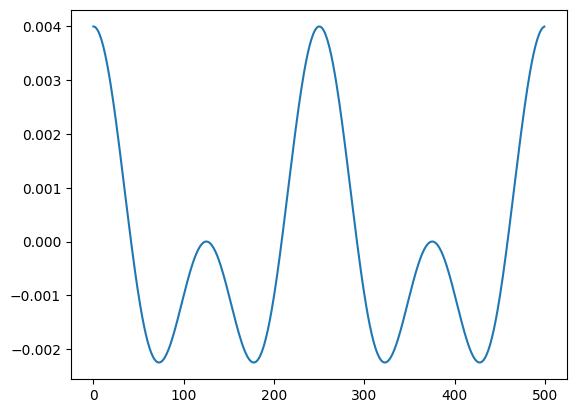

In [2]:
N = 500
coefs = np.zeros(N)
coefs[2] = 1
coefs[4] = 1
vals = jnp.fft.ifft(coefs)
vals = vals.real
plt.plot(vals)

In [3]:
from jax.tree_util import register_pytree_node
import copy


class Optimizable:
    def __init__(self, N, coefs):
        self.N = N
        self.set_coefs(coefs)

    def set_coefs(self, new_coefs):
        self.coefs = jnp.asarray(new_coefs)

    def N(self):
        return self.N

    def coefs(self):
        return self.coefs

    def copy(self):
        return copy.copy(self)

    def __repr__(self):
        return f"Optimizable(N={self.N}, coefs={self.coefs})"


def special_flatten_opt(obj):
    """Specifies a flattening recipe."""
    children = (obj.N, obj.coefs)
    aux_data = None
    return (children, aux_data)


def special_unflatten_opt(aux_data, children):
    """Specifies an unflattening recipe."""
    return Optimizable(*children)


class Objective:
    def __init__(self, opt, grid):
        self.opt = opt
        self.grid = grid
        # self.target = jnp.cos(grid)
        # self.target = grid**2 + grid + jnp.sin(grid)
        self.target = grid**2
        self.built = False

    def build(self):
        # the transform matrix A such that A @ coefs gives the
        # values of the function at the grid points
        self.A = jnp.vstack([jnp.cos(i * self.grid) for i in range(self.opt.N)]).T
        self.built = True

    @jax.jit
    def compute(self, coefs, A=None):
        if A is None:
            A = self.A
        vals = A @ coefs
        return vals

    @jax.jit
    def compute_error(self, coefs, A=None):
        if A is None:
            A = self.A
        vals = A @ coefs
        return vals - self.target

    @jax.jit
    def jac_error(self, coefs, A=None):
        if A is None:
            A = self.A
        return jax.jacfwd(self.compute_error)(coefs, A)

    @jax.jit
    def jac(self, coefs, A=None):
        if A is None:
            A = self.A
        return jax.jacfwd(self.compute)(coefs, A)


def special_flatten_obj(obj):
    """Specifies a flattening recipe."""
    children = (obj.opt, obj.grid)
    aux_data = None
    return (children, aux_data)


def special_unflatten_obj(aux_data, children):
    """Specifies an unflattening recipe."""
    return Objective(*children)


# Global registration
register_pytree_node(Optimizable, special_flatten_opt, special_unflatten_opt)
register_pytree_node(Objective, special_flatten_obj, special_unflatten_obj)

Text(0.5, 1.0, 'Converged in 500 steps')

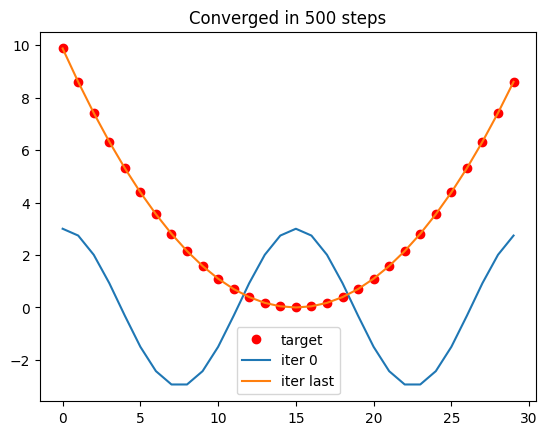

In [4]:
N = 40
num_nodes = 30
coefs = np.zeros(N)
coefs[2] = 3
eq = Optimizable(N, coefs)
grid = jnp.linspace(-jnp.pi, jnp.pi, num_nodes, endpoint=False)
obj = Objective(eq, grid)
obj.build()

plt.plot(obj.target, "or", label="target")
plt.plot(obj.compute(eq.coefs, obj.A), label=f"iter 0")
step = 0
# while jnp.linalg.norm(obj.compute_error(eq.coefs, obj.A)) > 1e-3:
for _ in range(500):
    eq.coefs = eq.coefs - 1e-1 * jnp.linalg.pinv(
        obj.jac_error(eq.coefs, obj.A)
    ) @ obj.compute_error(eq.coefs, obj.A)
    step += 1
plt.plot(obj.compute(eq.coefs, obj.A), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")

In [5]:
obj.jac(eq.coefs, obj.A).shape

(30, 40)

In [6]:
class ObjectiveFunction:
    def __init__(self, objectives):
        self.objectives = objectives
        self.built = False
        self.target = jnp.concatenate([obj.target for obj in self.objectives])

    def build(self):
        for obj in self.objectives:
            if not obj.built:
                obj.build()

        self.A = [obj.A for obj in self.objectives]
        self.built = True

    @jax.jit
    def compute(self, coefs, A=None):
        if A is None:
            A = self.A
        return jnp.concatenate(
            [obj.compute(coefs, Ai) for obj, Ai in zip(self.objectives, A)]
        )

    @jax.jit
    def compute_error(self, coefs, A=None):
        if A is None:
            A = self.A
        return jnp.concatenate(
            [obj.compute_error(coefs, Ai) for obj, Ai in zip(self.objectives, A)]
        )

    @jax.jit
    def jac_error(self, coefs, A=None):
        if A is None:
            A = self.A
        return jnp.vstack(
            [obj.jac_error(coefs, Ai) for obj, Ai in zip(self.objectives, A)]
        )

    @jax.jit
    def jac(self, coefs, A=None):
        if A is None:
            A = self.A
        return jnp.vstack([obj.jac(coefs, Ai) for obj, Ai in zip(self.objectives, A)])


def special_flatten_obj_fun(obj):
    """Specifies a flattening recipe."""
    children = (obj.objectives,)
    aux_data = None
    return (children, aux_data)


def special_unflatten_obj_fun(aux_data, children):
    """Specifies an unflattening recipe."""
    return ObjectiveFunction(*children)


register_pytree_node(
    ObjectiveFunction, special_flatten_obj_fun, special_unflatten_obj_fun
)

In [7]:
N = 40
num_nodes = 15
coefs = np.zeros(N)
coefs[2] = 3
eq = Optimizable(N, coefs)
grid1 = jnp.linspace(-jnp.pi, 0, num_nodes, endpoint=False)
grid2 = jnp.linspace(0, jnp.pi, num_nodes, endpoint=False)
grid3 = jnp.concatenate([grid1, grid2])

obj1 = Objective(eq, grid1)
obj2 = Objective(eq, grid2)
obj_fun = ObjectiveFunction([obj1, obj2])
obj_fun.build()

eq1 = eq.copy()
obj3 = Objective(eq1, grid3)
obj3.build()

Text(0.5, 1.0, 'Converged in 97 steps')

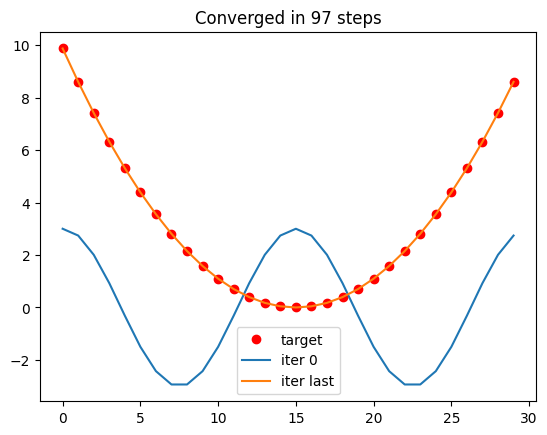

In [8]:
plt.plot(obj_fun.target, "or", label="target")
plt.plot(obj_fun.compute(eq.coefs, obj_fun.A), label=f"iter 0")
step = 0
while jnp.linalg.norm(obj_fun.compute_error(eq.coefs, obj_fun.A)) > 1e-3:
    eq.coefs = eq.coefs - 1e-1 * jnp.linalg.pinv(
        obj_fun.jac_error(eq.coefs, obj_fun.A)
    ) @ obj_fun.compute_error(eq.coefs, obj_fun.A)
    step += 1
    # plt.plot(obj_fun.compute(eq.coefs, obj_fun.A), label=f"iter {step}")
plt.plot(obj_fun.compute(eq.coefs, obj_fun.A), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")

Text(0.5, 1.0, 'Converged in 97 steps')

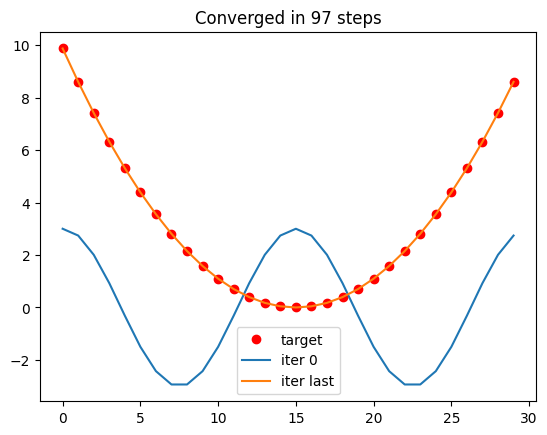

In [ ]:
plt.plot(obj3.target, "or", label="target")
plt.plot(obj3.compute(eq1.coefs, obj3.A), label=f"iter 0")
step = 0
while jnp.linalg.norm(obj3.compute_error(obj3.opt.coefs, obj3.A)) > 1e-3:
    eq1.coefs = eq1.coefs - 1e-1 * jnp.linalg.pinv(
        obj3.jac_error(eq1.coefs, obj3.A)
    ) @ obj3.compute_error(eq1.coefs, obj3.A)
    step += 1
plt.plot(obj3.compute(eq1.coefs, obj3.A), label=f"iter last")
plt.legend()
plt.title(f"Converged in {step} steps")